# Library

In [1]:
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.2 MB/s eta 0:00:00


In [ ]:
#pip install tensorflow-gpu==2.1

In [ ]:
#pip install keras

# Data loader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

DATA = '/content/drive/MyDrive/BTL NLP/train.csv'
DEV_DATA = '/content/drive/MyDrive/BTL NLP/val.csv'
TEST_DATA = '/content/drive/MyDrive/BTL NLP/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

print(len(train_data))
print(len(dev_data))
print(len(test_data))

X_train = train_data['text']
y_train = train_data['label'].values

X_dev = dev_data['text']
y_dev = dev_data['label'].values

X_test = test_data['text']
y_test = test_data['label'].values

43327
5416
5416


In [4]:
import pandas as pd
import numpy as np

from pyvi.ViTokenizer import ViTokenizer

# STOPWORDS = '/content/drive/MyDrive/MachineLearning/FinalTerm/ProcessingData/vietnamese-stopwords-dash.txt'
# with open(STOPWORDS, "r") as ins:
#     stopwords = []
#     for line in ins:
#         dd = line.strip('\n')
#         stopwords.append(dd)
#     stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    #text = ViTokenizer.tokenize(text) if tokenized else text
    # text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

In [5]:
# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

# Run models

## Text CNN (Convolutional neural network for text classification)

In [6]:
import keras
print(keras.__version__)

3.4.1


In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
# Text CNN
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [9]:
train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

#EMBEDDING_FILE = '/content/drive/MyDrive/MachineLearning/word2vec_vi_syllables_300dims.txt'
EMBEDDING_FILE = '/content/drive/MyDrive/BTL NLP/word2vec_vi_words_300dims.txt'
MODEL_FILE = '/content/drive/MyDrive/BTL NLP/Text_CNN_model_v13(Phow2v_Syllable).h5'

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    #X = sequence.pad_sequences(X, maxlen=sequence_length)
    X = pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=2)

    return X, y

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

In [10]:
# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)

In [11]:
#with open('drive/My Drive/CODE/HSD/tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)

In [13]:
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 300)       │     11,698,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 100, 300, 1)    │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 99, 1, 32)      │         19,232 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 98, 1, 32)      │         28,832 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 1, 32)      │         48,032 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 1, 1, 32)       │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 1, 1, 32)       │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 1, 1, 32)       │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3, 1, 32)       │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ max_pooling2d_1[0][0], │
│                           │                        │                │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 96)             │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 96)             │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │            194 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,794,490 (44.99 MB)

 Trainable params: 11,794,490 (44.99 MB)

 Non-trainable params: 0 (0.00 B)

### Syllable

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.7368 - loss: 0.6011 - val_accuracy: 0.7339 - val_loss: 0.5318
Epoch 2/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.7533 - loss: 0.5095 - val_accuracy: 0.7932 - val_loss: 0.4528
Epoch 3/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8093 - loss: 0.4264 - val_accuracy: 0.8268 - val_loss: 0.3933
Epoch 4/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8393 - loss: 0.3669 - val_accuracy: 0.8414 - val_loss: 0.3611
Epoch 5/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8619 - loss: 0.3216 - val_accuracy: 0.8534 - val_loss: 0.3441
Epoch 6/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8778 - loss: 0.2936 - val_accuracy: 0.8588 - val_loss: 0.3354
Epoch 7/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8919 - loss: 0.2649 - val_accuracy: 0.8637 - val_loss: 0.3314
Epoch 8/40
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9022 - loss: 0.2444 - val_accuracy: 0.8

[[3601  383]
 [ 509  923]]
F1 - micro: 0.8353028064992615
F1 - macro: 0.782004832552786
Accuracy: 0.8353028064992615


<Axes: >

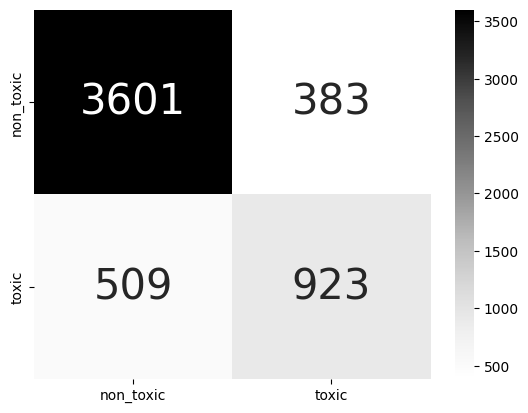

In [14]:
# checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["non_toxic","toxic"],
                  columns = ["non_toxic","toxic"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [15]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report  # Thêm vào đây
print("Classification Report:\n", classification_report(test_y, y_pred, target_names=["non_toxic", "toxic"]))


Classification Report:
               precision    recall  f1-score   support

   non_toxic       0.88      0.90      0.89      3984
       toxic       0.71      0.64      0.67      1432

    accuracy                           0.84      5416
   macro avg       0.79      0.77      0.78      5416
weighted avg       0.83      0.84      0.83      5416



### Testing for syllable

In [16]:
for i in range(len(y_pred)):
    if y_pred[i] != test_y[i]:
      print(test_data['text'][i], '|',y_pred[i] , '|', test_y[i])

chết đi | 0 | 1.0
bon giảng cảnh, sau_này gd bọn như_vậy, báo | 0 | 1.0
tiến chiểu giàu_có thiệt giúp_đỡ chúng_nó bay đi trốn | 0 | 1.0
toàn dv giỏi diễn_từ phản_diện chính_diện hây.mà tai_tiếng toàn p. | 1 | 0.0
no banh xac | 1 | 0.0
s người ta liên_hệ làm_việc tao bắt mày đi hả? điện thoại trưng nt gọi | 1 | 0.0
trách? trách cựu đại_uý công_an lê_thị hiền trách guồng_máy đào_tạo, sản_xuất mẫu!?! đại_uý hiền trường_hợp cá_biệt, tá, tướng, thứ_trưởng công_an ăn_cướp ăn_cướp gấp ngàn. tràn_lan tỉnh, thành,, huyện, rải nẻo đường_đất hàng triệu công_an bán_công an ăn_cướp. guồng_máy sản_xuất công_an!: thach vu | 0 | 1.0
địt mẹ tố_chất | 0 | 1.0
bây_giờ mê | 1 | 0.0
thu, chi, tích_cực tham_nhũng. dân khổ_sở bớt ngu đi 1,2 biến. | 1 | 0.0
thành_lập tổ_chức chỗ như_vầy quài đau_lòng chết | 0 | 1.0
tiền tịch_thu bây_giờ? hay_là ăn_chia ém_nhẹm? | 0 | 1.0
thầy lồn bữa kêu reaction vụ hương ly | 0 | 1.0
ngày_xưa như_vậy, cô_giáo chú_ý dùm cắn.. bảo bé cắn: hết_ý_kiến trường! | 1 | 0.0
nhỉnh mặt

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report  # Thêm vào đây
print("Classification Report:\n", classification_report(test_y, y_pred, target_names=["non_toxic", "toxic"]))


Classification Report:
               precision    recall  f1-score   support

   non_toxic       0.87      0.90      0.89      4479
       toxic       0.71      0.65      0.68      1687

    accuracy                           0.83      6166
   macro avg       0.79      0.77      0.78      6166
weighted avg       0.83      0.83      0.83      6166

